In [8]:
import yfinance as yf
import numpy as np
import pandas as pd
import cvxpy as cp

In [180]:
NUM_SIMULATIONS = 1000
NUM_TRADING_DAYS = 252


stocks_list = ['YESBANK.NS','GRASIM.NS','CIPLA.NS','TCS.NS','EMAMILTD.NS']
start_date = "2023-04-04"
end_date = "2024-04-04"

NUM_ASSETS = len(stocks_list)

In [181]:
# GATHER STOCK DATA

stock_data = {}

for stock in stocks_list:
    ticker = yf.Ticker(stock)
    stock_data[stock] = ticker.history(start=start_date, end=end_date)['Close']

stock_prices = pd.DataFrame(stock_data)

stock_prices

,YESBANK.NS,GRASIM.NS,CIPLA.NS,TCS.NS,EMAMILTD.NS
Date,,,,,
2023-04-05 00:00:00+05:30,15.250000,1643.649048,888.543640,3184.508057,351.816711
2023-04-06 00:00:00+05:30,15.400000,1653.356934,886.162903,3165.733887,349.210297
2023-04-10 00:00:00+05:30,15.200000,1694.169434,894.594543,3207.705322,352.554382
2023-04-11 00:00:00+05:30,15.200000,1695.011475,899.851929,3158.951904,354.226410
2023-04-12 00:00:00+05:30,15.400000,1701.301758,910.565063,3186.326416,352.898621
...,...,...,...,...,...
2024-03-27 00:00:00+05:30,23.150000,2207.350098,1463.349976,3840.899902,437.750000
2024-03-28 00:00:00+05:30,23.200001,2287.300049,1496.949951,3876.300049,429.350006
2024-04-01 00:00:00+05:30,24.450001,2292.550049,1498.650024,3916.750000,439.850006


In [203]:
stock_return = stock_prices.copy()
stock_return = np.log(stock_return / stock_return.shift(1))
stock_return = stock_return[1:]

np.array(stock_return.mean())

array([0.00209086, 0.00138671, 0.00206743, 0.00088006, 0.00090079])

In [204]:
cov_matrix = np.array(stock_return.cov())
expected_returns = np.array([0.00209086, 0.00138671, 0.00209086, 0.00088006, 0.00090079])

In [216]:
# TARGET RETURN & RISK TOLERANCE 

risk_tolerance = np.sqrt(stock_return.var()).mean()*(1+0.40)     # 40% of risk from asset with min risk
target_return = stock_return.mean().mean()                  # 65% of return from asset with max returns

# DEFINE THE VARIABLE FOR PORTFOLIO WEIGHTS

weights = cp.Variable(NUM_ASSETS)

# DEFINE THE EXPECTED RETURN & RISK OBJECTIVES

expected_return = cp.sum(expected_returns @ weights)
portfolio_risk = cp.quad_form(weights, cov_matrix)

# DEFINE THE OPTIMIZATION PROBLEM

constraints = [cp.sum(weights) == 1, expected_return >= target_return, portfolio_risk <= risk_tolerance, weights >= 0]
objective = cp.Maximize(expected_return)
problem = cp.Problem(objective, constraints)

In [217]:
# SOLVE THE MULTI-OBJECTIVE OPTIMISATION
problem.solve()

# EXTRACT PORTFOLIO WEIGHTS

portfolio_weights = weights.value

print("Portfolio Weights:")
print(portfolio_weights)
print("Portfolio Expected Return:", expected_return.value)
print("Portfolio Risk (Standard Deviation):", np.sqrt(portfolio_risk.value))

Portfolio Weights:
[4.33793088e-01 6.12900572e-08 5.66206768e-01 4.12709998e-08
 4.14173295e-08]
Portfolio Expected Return: 0.002090859857582146
Portfolio Risk (Standard Deviation): 0.014611925455505551


C:\Users\Ashish Dalal\AppData\Local\Programs\Python\Python311\Lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


In [207]:
# EFFICIENT FRONTIER

risk_values = []
return_values = []

for r in np.linspace(0.05,0.15,100):
    expected_return = cp.sum(expected_returns@weights)
    portfolio_risk = cp.quad_form(weights, cov_matrix)
    
    constraints = [cp.sum(weights)==1, expected_return == r]
    problem = cp.Problem(cp.Minimize(portfolio_risk), constraints)
    
    problem.solve()
    
    risk_values.append(np.sqrt(portfolio_risk.value))
    return_values.append(r)

In [218]:
risk_values = []
return_values = []

for r in np.linspace(0.05, 0.15, 100):
    expected_return = cp.sum(expected_returns @ weights)
    portfolio_risk = cp.quad_form(weights, cov_matrix)
    constraints = [cp.sum(weights) == 1, expected_return == r]
    problem = cp.Problem(cp.Minimize(portfolio_risk), constraints)
    problem.solve()
    risk_values.append(np.sqrt(portfolio_risk.value))
    return_values.append(r)

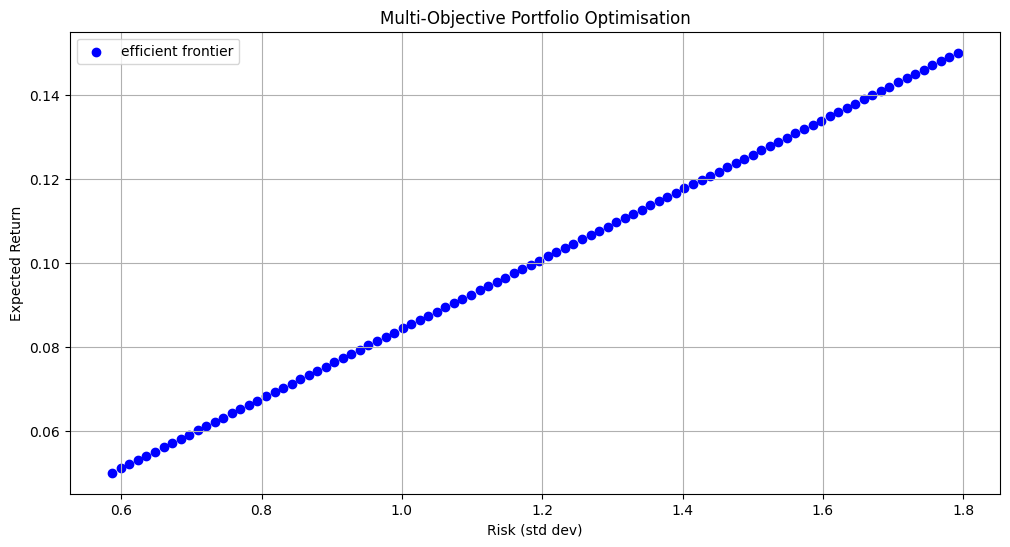

In [219]:
plt.figure(figsize=(12,6))
plt.scatter(risk_values, return_values, c='b', marker='o', label='efficient frontier')
plt.xlabel('Risk (std dev)')
plt.ylabel('Expected Return')
plt.title('Multi-Objective Portfolio Optimisation')
plt.grid()
plt.legend()
plt.show()